In [1]:
import albumentations as A
import torch
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2

from torch.utils.data import DataLoader
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.image import load_image
from torchlake.common.models import ResNetFeatureExtractor
from torchlake.image_classification.models.darknet19 import DarkNet19FeatureExtractor
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.object_detection.constants.schema import DetectorContext
from torchlake.common.datasets.voc import VOCDetectionFromCSV, VOCDetectionFromLMDB
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.object_detection.utils.train import collate_fn
from torchlake.object_detection.controller.trainer_yolov2 import YOLOV2Trainer
from torchlake.common.controller.recorder import TrainRecorder

from torchlake.object_detection.models.yolov2 import YOLOV2, YOLOV2Loss, PriorBox
from torchlake.object_detection.utils.plot import draw_pred
from torchlake.common.controller.weight_manager import WeightManager

d:\research\pytorch-implementations\gits\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\research\pytorch-implementations\gits\.venv\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
from pathlib import Path

import matplotlib.pyplot as plt

# setting

In [3]:
artifact_path = Path('../../artifacts/yolov2')
artifact_path.mkdir(exist_ok=True)

In [4]:
data_path = Path("../../data/VOCdevkit")

In [5]:
NUM_CLASS = len(VOC_CLASS_NAMES)
NUM_ANCHORS = 5

In [6]:
CONTEXT = DetectorContext(
    detector_name="yolov2",
    dataset="VOC",
    device="cuda:0",
    num_classes=NUM_CLASS,
    num_anchors=NUM_ANCHORS,
    anchors_path=artifact_path.joinpath("voc.anchors.416.txt").as_posix(),
)

# data

In [7]:
BATCH_SIZE = 64

In [8]:
IMAGE_SIZE = 416

In [9]:
transform = A.Compose(
    [
        A.ColorJitter(p=0.3),
        A.HorizontalFlip(),
        # A.ShiftScaleRotate(p=0.5, rotate_limit=0),
        A.RandomSizedBBoxSafeCrop(IMAGE_SIZE, IMAGE_SIZE, erosion_rate=0.1),
        # A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
        format="yolo",
        # min_area=1024,
        # min_visibility=0.3,
    ),
)

In [10]:
train_dataset = VOCDetectionFromLMDB(
    data_path.joinpath("voc").as_posix(),
    transform=transform,
)

In [11]:
# train_dataset.env.close()

In [12]:
for x, y in train_dataset:
    print(x.shape, len(y))
    break

torch.Size([3, 416, 416]) 1


In [13]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [14]:
for x, y in train_loader:
    print(x.shape, len(y))
    break

torch.Size([64, 3, 416, 416]) 64


# model

If you don't have anchors yet, build one in debug section

In [15]:
backbone = ResNetFeatureExtractor("resnet34", "block", trainable=True)
backbone.fix_target_layers(["3_1", "4_1"])

In [16]:
# backbone = DarkNet19FeatureExtractor("last_conv", "../../artifacts/darknet19/darknet19_448.pth", trainable=True)
# backbone.fix_target_layers(["3_1", "4_1"])

In [17]:
model = YOLOV2(
    backbone,
    CONTEXT,
    passthrough_feature_dim=backbone.feature_dims[-2],
    neck_feature_dim=backbone.feature_dims[-1],
).to(CONTEXT.device)

In [18]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
YOLOV2                                             --
├─ResNetFeatureExtractor: 1-1                      --
│    └─ResNet: 2-1                                 --
│    │    └─Conv2d: 3-1                            9,408
│    │    └─BatchNorm2d: 3-2                       128
│    │    └─ReLU: 3-3                              --
│    │    └─MaxPool2d: 3-4                         --
│    │    └─Module: 3-5                            221,952
│    │    └─Module: 3-6                            1,116,416
│    │    └─Module: 3-7                            6,822,400
│    │    └─Module: 3-8                            13,114,368
│    │    └─AdaptiveAvgPool2d: 3-9                 --
│    └─ImageNetNormalization: 2-2                  --
├─ModuleDict: 1-2                                  --
│    └─Sequential: 2-3                             --
│    │    └─Conv2dNormActivation: 3-10             8,256
│    │    └─StackedPatch2d: 3-11           

In [19]:
priorBox = PriorBox(CONTEXT)
anchors = priorBox.load_anchors()

# train

In [ ]:
EPOCH = 50

In [21]:
trainer = YOLOV2Trainer(EPOCH, CONTEXT.device)

In [22]:
recorder = TrainRecorder(0, EPOCH, num_loss=1)
recorder.increment_data_size(len(train_dataset))

In [23]:
# underestimate the loss, since we drop last batch
recorder.data_size

16551

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = YOLOV2Loss(
    anchors,
    CONTEXT,
    prior_loss_threshold=BATCH_SIZE * 258, # one epoch
    return_all_loss=False,
)

In [25]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [26]:
scaler = torch.amp.GradScaler()

In [27]:
def validate_func(model):
    from torchlake.object_detection.models.yolov2.decode import Decoder
    from torchlake.object_detection.configs.schema import InferenceCfg
    from torchlake.object_detection.controller.predictor import Predictor
    from torchlake.object_detection.controller.evaluator import Evaluator
    
    decoder = Decoder(anchors.to("cpu"), CONTEXT)
    inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.3, NMS_THRESH=0.5)
    
    predictor = Predictor(CONTEXT)
    predictor.set_postprocess_cfg(decoder, inferCfg)
    
    test_transform = A.Compose(
        [
            A.Resize(IMAGE_SIZE, IMAGE_SIZE),
            A.Normalize(0, 1),
            ToTensorV2(),
        ]
    )
    
    test_dataset = VOCDetectionFromCSV(
        data_path,
        data_path.joinpath("voc_test.csv"),
        transform=test_transform,
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        pin_memory=True,
        # num_workers=get_num_workers(),
        collate_fn=collate_fn,
    )
    
    evaluator = Evaluator(CONTEXT)
    
    result_table = evaluator.run(predictor, model, test_loader, VOC_CLASS_NAMES, verbose=False)
    
    print("validation mAP:", result_table['all'])

In [28]:
manager = WeightManager(artifact_path.joinpath("yolov2.{backbone_name}.{epoch}.pth").as_posix())
optimizer_manager = WeightManager(artifact_path.joinpath("adam.{lr}.{decay}.{epoch}.pth").as_posix())

In [ ]:
def checkpoint_func(model: YOLOV2, optimizer: torch.optim.Optimizer):
    filename = manager.get_filename(
        backbone_name=model.foot.network_name,
        epoch=recorder.current_epoch,
    )
    manager.save_weight(model.state_dict(), filename)
    
    param_group = optimizer.param_groups[0]
    filename = optimizer_manager.get_filename(
        lr=param_group['lr'],
        decay=param_group['weight_decay'],
        epoch=recorder.current_epoch,
    )
    optimizer_manager.save_weight(optimizer.state_dict(), filename)

In [30]:
trainer.reset_seen()

In [31]:
training_loss = trainer.run(
    train_loader,
    model,
    optimizer,
    criterion,
    scheduler=scheduler,
    recorder=recorder,
    scaler=scaler,
    validate_func=validate_func,
    checkpoint_func=checkpoint_func, 
)

Enable AMP: True
Training...


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 1
------------------------------------
35.733037721238546 (0%)


100%|██████████| 258/258 [03:53<00:00,  1.10it/s]


------------------------------------
Epoch 2
------------------------------------
9.35399958426322 (-74%)


100%|██████████| 258/258 [03:53<00:00,  1.11it/s]


------------------------------------
Epoch 3
------------------------------------
7.207497830967422 (-23%)


100%|██████████| 258/258 [03:52<00:00,  1.11it/s]


------------------------------------
Epoch 4
------------------------------------
6.242021610568164 (-13%)


100%|██████████| 258/258 [03:52<00:00,  1.11it/s]


------------------------------------
Epoch 5
------------------------------------
5.53933811055217 (-11%)


100%|██████████| 258/258 [03:53<00:00,  1.11it/s]


------------------------------------
Epoch 6
------------------------------------
5.142297017927956 (-7%)


100%|██████████| 258/258 [03:52<00:00,  1.11it/s]


------------------------------------
Epoch 7
------------------------------------
4.778589775652895 (-7%)


100%|██████████| 258/258 [03:52<00:00,  1.11it/s]


------------------------------------
Epoch 8
------------------------------------
4.4543141889454025 (-7%)


100%|██████████| 258/258 [03:53<00:00,  1.11it/s]


------------------------------------
Epoch 9
------------------------------------
4.27421415032926 (-4%)


100%|██████████| 258/258 [03:58<00:00,  1.08it/s]


------------------------------------
Epoch 10
------------------------------------
4.026924109791682 (-6%)
Validating...


100%|██████████| 78/78 [01:15<00:00,  1.04it/s]


validation mAP: AP@0.5    0.532613
Name: all, dtype: float64
Checkpoint...
..\..\artifacts\yolov2\yolov2.resnet34.10.pth
Save weight to ..\..\artifacts\yolov2\yolov2.resnet34.10.pth, model size is 176.41MiB
Save weight to ..\..\artifacts\yolov2\adam.0.0001.1e-05.10.pth, model size is 352.58MiB


100%|██████████| 258/258 [03:38<00:00,  1.18it/s]


------------------------------------
Epoch 11
------------------------------------
5.001334841190441 (24%)


100%|██████████| 258/258 [03:52<00:00,  1.11it/s]


------------------------------------
Epoch 12
------------------------------------
4.434368083530461 (-11%)


100%|██████████| 258/258 [03:52<00:00,  1.11it/s]


------------------------------------
Epoch 13
------------------------------------
4.1403282810414215 (-7%)


100%|██████████| 258/258 [03:52<00:00,  1.11it/s]


------------------------------------
Epoch 14
------------------------------------
3.2342078802585723 (-22%)


100%|██████████| 258/258 [03:52<00:00,  1.11it/s]


------------------------------------
Epoch 15
------------------------------------
2.9680740506719157 (-8%)


100%|██████████| 258/258 [03:52<00:00,  1.11it/s]


------------------------------------
Epoch 16
------------------------------------
2.8242991137854627 (-5%)


100%|██████████| 258/258 [03:52<00:00,  1.11it/s]


------------------------------------
Epoch 17
------------------------------------
2.8406185951991216 (1%)


100%|██████████| 258/258 [03:52<00:00,  1.11it/s]


------------------------------------
Epoch 18
------------------------------------
2.6942816342438016 (-5%)


100%|██████████| 258/258 [03:51<00:00,  1.11it/s]


------------------------------------
Epoch 19
------------------------------------
2.671551105904223 (-1%)


100%|██████████| 258/258 [03:51<00:00,  1.11it/s]


------------------------------------
Epoch 20
------------------------------------
2.602827719680982 (-3%)
Validating...


100%|██████████| 78/78 [01:24<00:00,  1.08s/it]


validation mAP: AP@0.5    0.619401
Name: all, dtype: float64
Checkpoint...
..\..\artifacts\yolov2\yolov2.resnet34.20.pth
Save weight to ..\..\artifacts\yolov2\yolov2.resnet34.20.pth, model size is 176.41MiB
Save weight to ..\..\artifacts\yolov2\adam.1e-05.1e-05.20.pth, model size is 352.58MiB


100%|██████████| 258/258 [03:52<00:00,  1.11it/s]


------------------------------------
Epoch 21
------------------------------------
2.5442636400095666 (-2%)


100%|██████████| 258/258 [03:52<00:00,  1.11it/s]


------------------------------------
Epoch 22
------------------------------------
2.444106912765607 (-4%)


100%|██████████| 258/258 [03:52<00:00,  1.11it/s]


------------------------------------
Epoch 23
------------------------------------
2.4626121108434433 (1%)


100%|██████████| 258/258 [02:48<00:00,  1.53it/s]


------------------------------------
Epoch 24
------------------------------------
2.379982682846299 (-3%)


100%|██████████| 258/258 [02:37<00:00,  1.64it/s]


------------------------------------
Epoch 25
------------------------------------
2.404431106892821 (1%)


100%|██████████| 258/258 [02:37<00:00,  1.64it/s]


------------------------------------
Epoch 26
------------------------------------
2.351234280460227 (-2%)


100%|██████████| 258/258 [02:36<00:00,  1.65it/s]


------------------------------------
Epoch 27
------------------------------------
2.310161337277138 (-2%)


100%|██████████| 258/258 [02:36<00:00,  1.65it/s]


------------------------------------
Epoch 28
------------------------------------
2.2149253219688405 (-4%)


100%|██████████| 258/258 [02:36<00:00,  1.65it/s]


------------------------------------
Epoch 29
------------------------------------
2.168587272588267 (-2%)


100%|██████████| 258/258 [02:37<00:00,  1.63it/s]


------------------------------------
Epoch 30
------------------------------------
2.1834305440628317 (1%)
Validating...


100%|██████████| 78/78 [01:11<00:00,  1.10it/s]


validation mAP: AP@0.5    0.640397
Name: all, dtype: float64
Checkpoint...
..\..\artifacts\yolov2\yolov2.resnet34.30.pth
Save weight to ..\..\artifacts\yolov2\yolov2.resnet34.30.pth, model size is 176.41MiB
Save weight to ..\..\artifacts\yolov2\adam.1.0000000000000002e-06.1e-05.30.pth, model size is 352.58MiB


100%|██████████| 258/258 [02:38<00:00,  1.63it/s]


------------------------------------
Epoch 31
------------------------------------
2.1731385657466227 (0%)


100%|██████████| 258/258 [02:37<00:00,  1.63it/s]


------------------------------------
Epoch 32
------------------------------------
2.17123714832156 (0%)


100%|██████████| 258/258 [02:37<00:00,  1.63it/s]


------------------------------------
Epoch 33
------------------------------------
2.185492221412107 (1%)


100%|██████████| 258/258 [02:37<00:00,  1.64it/s]


------------------------------------
Epoch 34
------------------------------------
2.1372967136280026 (-2%)


100%|██████████| 258/258 [02:38<00:00,  1.62it/s]


------------------------------------
Epoch 35
------------------------------------
2.187932176090396 (2%)


100%|██████████| 258/258 [02:39<00:00,  1.62it/s]


------------------------------------
Epoch 36
------------------------------------
2.084880948938219 (-5%)


100%|██████████| 258/258 [04:03<00:00,  1.06it/s]


------------------------------------
Epoch 37
------------------------------------
2.1665284739513844 (4%)


100%|██████████| 258/258 [04:07<00:00,  1.04it/s]


------------------------------------
Epoch 38
------------------------------------
2.0977436725081056 (-3%)


100%|██████████| 258/258 [03:57<00:00,  1.09it/s]


------------------------------------
Epoch 39
------------------------------------
2.140545631894087 (2%)


100%|██████████| 258/258 [03:58<00:00,  1.08it/s]


------------------------------------
Epoch 40
------------------------------------
2.2087055215748546 (3%)
Validating...


100%|██████████| 78/78 [01:35<00:00,  1.23s/it]


validation mAP: AP@0.5    0.642533
Name: all, dtype: float64
Checkpoint...
..\..\artifacts\yolov2\yolov2.resnet34.40.pth
Save weight to ..\..\artifacts\yolov2\yolov2.resnet34.40.pth, model size is 176.41MiB
Save weight to ..\..\artifacts\yolov2\adam.1.0000000000000004e-08.1e-05.40.pth, model size is 352.58MiB


100%|██████████| 258/258 [03:59<00:00,  1.08it/s]


------------------------------------
Epoch 41
------------------------------------
2.1629953514045197 (-2%)


100%|██████████| 258/258 [04:00<00:00,  1.07it/s]


------------------------------------
Epoch 42
------------------------------------
2.1369534680853572 (-1%)


100%|██████████| 258/258 [04:01<00:00,  1.07it/s]


------------------------------------
Epoch 43
------------------------------------
2.165101684520527 (1%)


100%|██████████| 258/258 [04:04<00:00,  1.05it/s]


------------------------------------
Epoch 44
------------------------------------
2.1566585065749355 (0%)


100%|██████████| 258/258 [03:47<00:00,  1.14it/s]


------------------------------------
Epoch 45
------------------------------------
2.1850812551399197 (1%)


100%|██████████| 258/258 [03:45<00:00,  1.15it/s]


------------------------------------
Epoch 46
------------------------------------
2.13502133071952 (-2%)


100%|██████████| 258/258 [04:08<00:00,  1.04it/s]


------------------------------------
Epoch 47
------------------------------------
2.1637754854597886 (1%)


100%|██████████| 258/258 [04:03<00:00,  1.06it/s]


------------------------------------
Epoch 48
------------------------------------
2.1740829735592806 (0%)


100%|██████████| 258/258 [03:47<00:00,  1.14it/s]


------------------------------------
Epoch 49
------------------------------------
2.1490283629792124 (-1%)


100%|██████████| 258/258 [03:47<00:00,  1.13it/s]


------------------------------------
Epoch 50
------------------------------------
2.169799490541384 (1%)
Validating...


100%|██████████| 78/78 [01:30<00:00,  1.16s/it]


validation mAP: AP@0.5    0.642959
Name: all, dtype: float64
Checkpoint...
..\..\artifacts\yolov2\yolov2.resnet34.50.pth
Save weight to ..\..\artifacts\yolov2\yolov2.resnet34.50.pth, model size is 176.41MiB
Save weight to ..\..\artifacts\yolov2\adam.1.0000000000000004e-08.1e-05.50.pth, model size is 352.58MiB


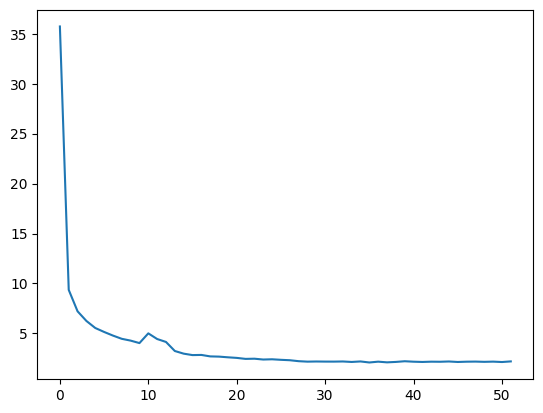

In [32]:
plt.plot(torch.Tensor(recorder.training_losses).T)

# load

In [ ]:
manager = WeightManager(artifact_path.joinpath("{detector_name}.{backbone_name}.{epoch}.pth").as_posix())

In [85]:
model_path = manager.get_filename(
    detector_name=CONTEXT.detector_name,
    backbone_name=backbone.network_name,
    # epoch=recorder.current_epoch,
    epoch=10,
)

In [ ]:
model_path

WindowsPath('../../artifacts/yolov2/yolov2.resnet34.10.prior.pth')

In [ ]:
# manager.save_weight(model.state_dict(), model_path)

Save weight to ..\..\artifacts\yolov2\yolov2.resnet34.10.prior.pth, model size is 176.41MiB


In [ ]:
manager.load_weight(model_path, model)

# Inference

In [33]:
from tqdm import tqdm
from torchlake.object_detection.models.yolov2.decode import Decoder
from torchlake.object_detection.configs.schema import InferenceCfg
from torchlake.object_detection.controller.predictor import Predictor

In [34]:
decoder = Decoder(anchors.to("cpu"), CONTEXT)
inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.3, NMS_THRESH=0.5)

In [35]:
predictor = Predictor(CONTEXT)
predictor.set_postprocess_cfg(decoder, inferCfg)

In [36]:
test_transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    # bbox_params=A.BboxParams(
    #     format="yolo",
    #     # min_area=1024,
    #     # min_visibility=0.3,
    # ),
)

In [37]:
import numpy as np
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import rand_color_map, plot_grids

In [38]:
color_map = rand_color_map(VOC_CLASS_NAMES)

In [39]:
test_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_test.csv"),
    transform=test_transform,
)

In [40]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    # num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [41]:
model.eval()
with torch.no_grad():
    for img, _ in tqdm(test_loader):
        img = img.to(CONTEXT.device)

        # B x (?, 25)
        output = predictor.detect_image(model, img, is_batch=True)
        break

  0%|          | 0/77 [00:01<?, ?it/s]


In [38]:
# model.eval()
# with torch.no_grad():
#     output = model(img)
#     decoded = decoder.decode(output.cpu(), (IMAGE_SIZE, IMAGE_SIZE))
#     boxes = decoded[4]
#     # boxes = output[0].unflatten(0, (5, 25)).permute(0, 2, 3, 1).reshape(-1, 25)
#     print(boxes[boxes[:, 4] > 0.1])

In [56]:
# boxes[169*1:169*2, 4]

In [42]:
placeholder = []
for im, o in zip(img, output):
    overlay = img_tensor_to_np(im, 255, np.uint8)
    draw_pred(
        overlay,
        o,
        class_names=VOC_CLASS_NAMES,
        class_colors=color_map,
    )
    placeholder.append(overlay)

person: 0.35
person: 0.53
person: 0.39
person: 0.99
person: 1.00
bus: 0.99
person: 1.00
person: 1.00
person: 0.99
bottle: 0.82
person: 0.61
person: 0.65
person: 0.99
person: 0.98
train: 1.00
bus: 0.95
car: 0.50
person: 0.59
chair: 0.92
chair: 0.56
sofa: 0.98
tvmonitor: 0.92
tvmonitor: 0.93
pottedplant: 0.84
pottedplant: 0.99
sofa: 0.85
cow: 0.54
cow: 0.49
horse: 0.44
dog: 0.99
chair: 0.86
person: 0.80
person: 0.94
person: 0.99
sheep: 0.97
bicycle: 1.00
chair: 0.44
chair: 0.68
chair: 0.95
chair: 0.87
chair: 0.58
chair: 0.36
chair: 0.88
chair: 0.65
chair: 0.66
chair: 0.94
person: 0.39
person: 0.72
person: 0.77
person: 0.62
person: 0.72
person: 0.79
person: 0.39
person: 0.63
person: 0.72
person: 0.58
person: 0.82
person: 0.74
person: 0.72
person: 0.45
person: 1.00
person: 0.93
cat: 0.73
person: 0.94
person: 0.58
person: 0.64
person: 0.94
person: 0.30
person: 0.33
person: 0.69
person: 0.93
person: 0.50
tvmonitor: 0.33
tvmonitor: 0.84
tvmonitor: 0.75
car: 1.00
bottle: 0.59
bottle: 0.72
bott

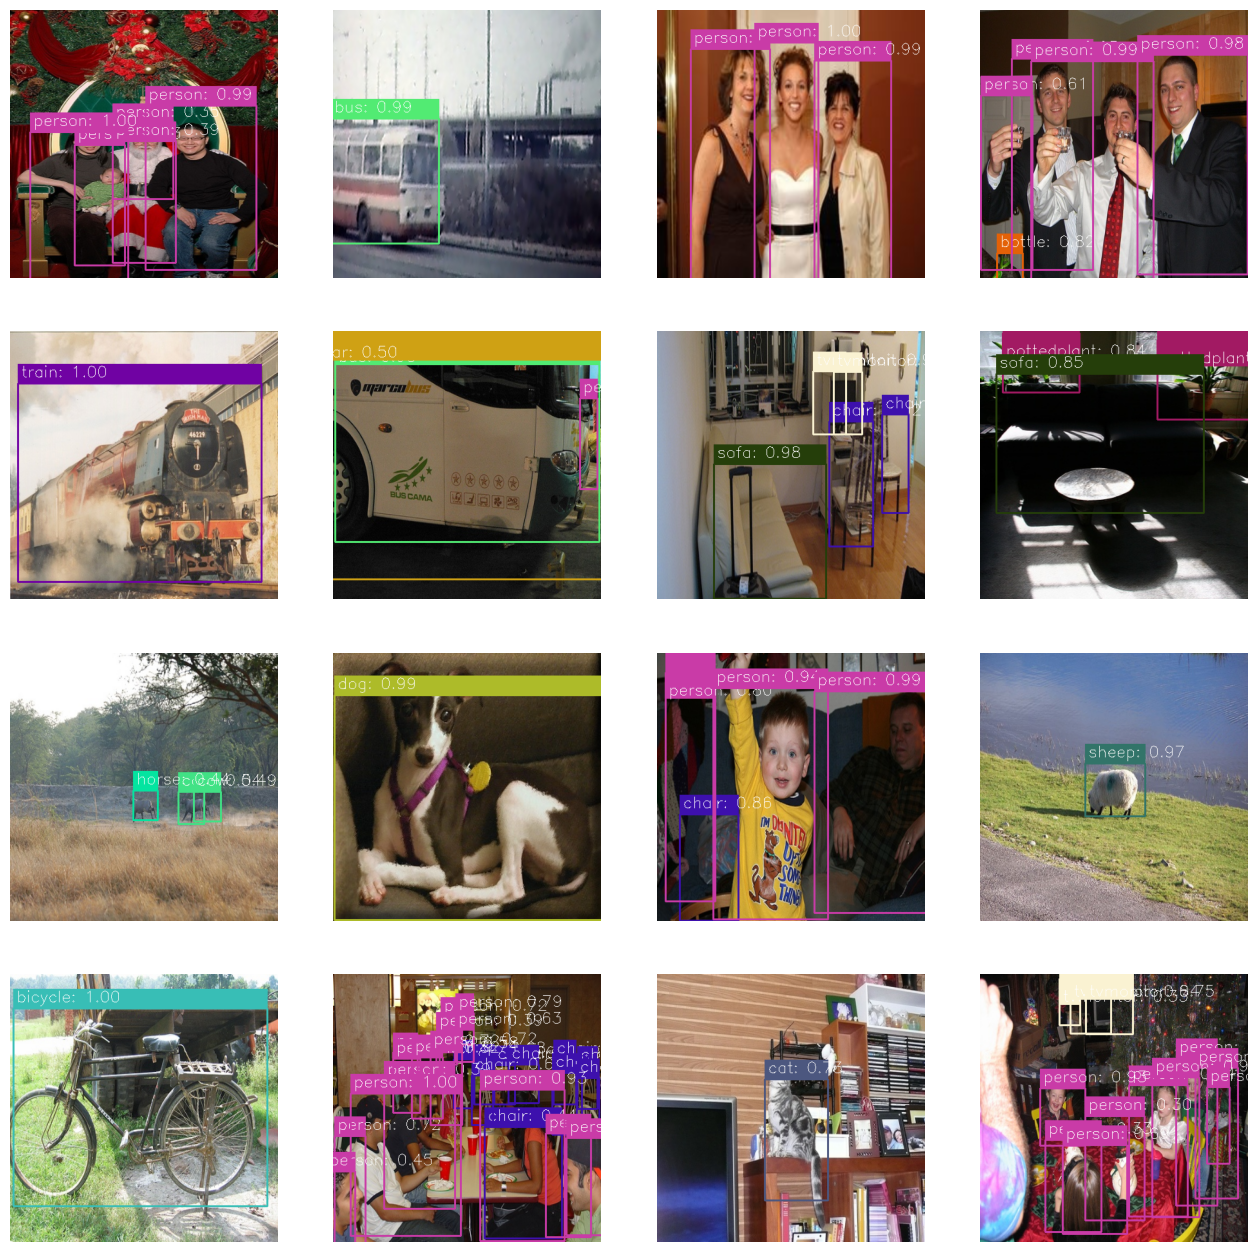

In [43]:
plot_grids(
    placeholder[:16],
    num_row=4,
    num_col=4,
    figsize=(16,16),
)

In [44]:
humans_img = "D://research/pytorch-implementations/data/coco/train2017/000000000165.jpg"
human_img = "D://W/hmm/Screenshot_20240612_091521.jpg"
obj_img = "D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg"

predictor.predict_image_file(
    model,
    [humans_img, human_img, obj_img],
    VOC_CLASS_NAMES,
    color_map,
    test_transform,
    show=False,
    save_dir=artifact_path.as_posix(),
)

person: 1.00
person: 0.98
D://research/pytorch-implementations/data/coco/train2017/000000000165.jpg 2
person: 0.98
D://W/hmm/Screenshot_20240612_091521.jpg 1
aeroplane: 1.00
aeroplane: 0.91
aeroplane: 0.35
aeroplane: 0.48
boat: 0.41
D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg 5


In [ ]:
predictor.predict_video_file(
    model,
    "../../data/movie.mp4",
    VOC_CLASS_NAMES,
    color_map,
    test_transform,
    show=False,
    save_dir=artifact_path.as_posix(),
)

# evaluate

In [46]:
from torchlake.object_detection.models.yolov2.decode import Decoder
from torchlake.object_detection.configs.schema import InferenceCfg
from torchlake.object_detection.controller.predictor import Predictor
from torchlake.object_detection.controller.evaluator import Evaluator

In [47]:
VAL_IMAGE_SIZE = 416

In [48]:
decoder = Decoder(anchors.to("cpu"), CONTEXT)
inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.3, NMS_THRESH=0.5)

In [49]:
predictor = Predictor(CONTEXT)
predictor.set_postprocess_cfg(decoder, inferCfg)

In [50]:
test_transform = A.Compose(
    [
        A.Resize(VAL_IMAGE_SIZE, VAL_IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
        format="yolo",
        # min_area=1024,
        # min_visibility=0.3,
    ),
)

In [51]:
test_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_test.csv"),
    transform=test_transform,
)

In [52]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    # shuffle=True,
    pin_memory=True,
    # num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [53]:
evaluator = Evaluator(CONTEXT)

In [54]:
result_table = evaluator.run(predictor, model, test_loader, VOC_CLASS_NAMES)

100%|██████████| 78/78 [01:21<00:00,  1.04s/it]


       aeroplane  bicycle      bird      boat    bottle      bus       car  \
AP@0.5  0.683317  0.69545  0.674431  0.648512  0.550433  0.56738  0.631551   

             cat     chair       cow  ...       dog     horse motorbike  \
AP@0.5  0.650156  0.631368  0.630651  ...  0.659601  0.668583  0.672588   

          person pottedplant     sheep      sofa    train tvmonitor       all  
AP@0.5  0.654696    0.645438  0.646222  0.647711  0.65344   0.65334  0.645356  

[1 rows x 21 columns]


In [55]:
result_table.T

,AP@0.5
aeroplane,0.683317
bicycle,0.69545
bird,0.674431
boat,0.648512
bottle,0.550433
bus,0.56738
car,0.631551
cat,0.650156
chair,0.631368
cow,0.630651


# further evaluation

# debug

## draw anchors

In [24]:
VAL_IMAGE_SIZE = 416

In [25]:
test_transform = A.Compose(
    [
        A.Resize(VAL_IMAGE_SIZE, VAL_IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
        format="yolo",
        # min_area=1024,
        # min_visibility=0.3,
    ),
)

In [26]:
train_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_trainval.csv"),
    transform=test_transform,
)

In [ ]:
if not (Path(CONTEXT.anchors_path).exists() and Path(CONTEXT.anchors_path).is_file()):
    p = PriorBox(CONTEXT)
    anchors = p.build_anchors(train_dataset.table[["w", "h"]].to_numpy())
    p.save_anchors(anchors)

gt shape:  torch.Size([40058, 2])
init evaluation score: 0.5776740074157715
new evaluation score: 0.6373701095581055
new evaluation score: 0.6394929051399231
final mean IOU:  0.6394929051399231
member count of each group:  [4494, 11716, 6708, 6689, 10451]


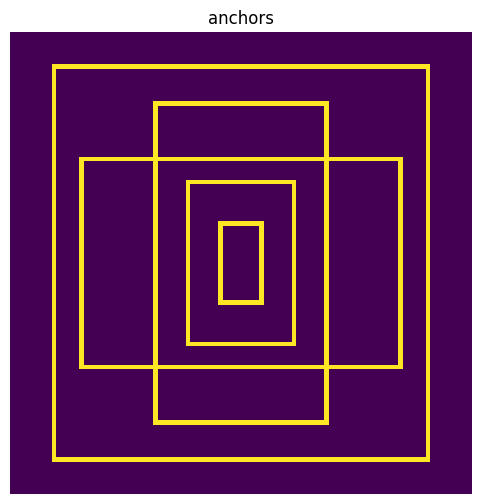

In [173]:
from torchlake.object_detection.utils.plot import draw_anchors
from torchlake.object_detection.models.yolov2 import PriorBox
from torchlake.object_detection.utils.config import load_anchors
from torchlake.common.utils.plot import plot_grids

box = PriorBox(CONTEXT)
anchors = load_anchors(CONTEXT.anchors_path)

canvas = [draw_anchors(anchors)]

plot_grids(
    canvas,
    ["anchors"],
    1,
    1,
    figsize=(8,6),
)

In [123]:
from copy import deepcopy

CONTEXT_FOR_ANCHORS = deepcopy(CONTEXT)
CONTEXT_FOR_ANCHORS.anchors_path = artifact_path.joinpath("voc.anchors.416.txt")

In [130]:
wh = []
for _, labels in train_dataset:
    wh.extend(labels)

wh = torch.Tensor(wh)[:, 2:4]

In [ ]:
if not (Path(CONTEXT_FOR_ANCHORS.anchors_path).exists() and Path(CONTEXT_FOR_ANCHORS.anchors_path).is_file()):
    p = PriorBox(CONTEXT_FOR_ANCHORS)
    anchors = p.build_anchors(wh)
    p.save_anchors(anchors)

gt shape:  torch.Size([40058, 2])
init evaluation score: 0.5904454588890076
new evaluation score: 0.6173481583595276
new evaluation score: 0.6272975206375122
final mean IOU:  0.6272975206375122
member count of each group:  [8892, 6324, 14151, 5986, 4705]


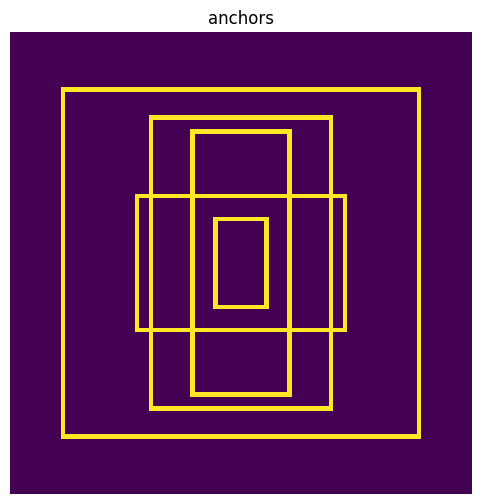

In [287]:
from torchlake.object_detection.utils.plot import draw_anchors
from torchlake.object_detection.models.yolov2 import PriorBox
from torchlake.object_detection.utils.config import load_anchors
from torchlake.common.utils.plot import plot_grids

box = PriorBox(CONTEXT_FOR_ANCHORS)
anchors = box.load_anchors()

canvas = [draw_anchors(anchors[0, :, :, 0, 0])]

plot_grids(
    canvas,
    ["anchors"],
    1,
    1,
    figsize=(8,6),
)

## match

In [25]:
from torchlake.object_detection.utils.train import build_flatten_targets
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.object_detection.utils.plot import draw_label
from torchlake.object_detection.utils.train import generate_grid_train

In [26]:
criterion = YOLOV2Loss(anchors, CONTEXT)

In [27]:
for x, y in train_loader:
    break

In [54]:
t, span = build_flatten_targets(y, (13, 13), delta_coord=True)

In [197]:
batch_idx = 6

In [198]:
cloned_image = img_tensor_to_np(x[batch_idx])

In [199]:
model.eval()
with torch.no_grad():
    output = model(x.to(CONTEXT.device))
    output = output.unflatten(1, (5, 25))
    output[:, :, :2, :, :] = output[:, :, :2, :, :].sigmoid()
    output[:, :, 4, :, :] = output[:, :, 4, :, :].sigmoid()
    output[:, :, 5:, :, :] = output[:, :, 5:, :, :].softmax(2)

In [200]:
output.shape

torch.Size([64, 5, 25, 13, 13])

In [201]:
matched, positivity = criterion.match(t.to(CONTEXT.device), span, output, 13, 13)
matched, positivity = [m.to("cpu") for m in matched], positivity.to("cpu")

In [202]:
matched[batch_idx], span[batch_idx], positivity[batch_idx]

(tensor([[ 1.2205e-02,  2.1231e-02,  1.4878e-01, -4.6301e-01,  1.8000e+01,
           0.0000e+00,  5.1160e+03]]),
 1,
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [203]:
# iou
matched[batch_idx][:, 5].long()

tensor([0])

In [204]:
# best box indices
matched[batch_idx][:, 6].long()

tensor([5116])

In [205]:
positivity.shape

torch.Size([64, 845])

In [206]:
# check if positivity correct
positivity.view(-1)[matched[batch_idx][:, 6].long()].eq(1).all().item()

True

In [207]:
positivity.view(-1)[matched[batch_idx][:, 6].long()].eq(2).sum()

tensor(0)

In [208]:
# candidate index among A*H*W
# candidates = torch.arange(845).to(CONTEXT.device)[positivity.long()[0:sum(span[:1])]]
candidates = matched[batch_idx][:, 6].long() % 845

In [209]:
anchors_no, cells_no = candidates // (13 * 13), candidates % (13*13)
cells_h, cells_w = cells_no // 13, cells_no % 13
anchors_no, cells_no, cells_h, cells_w

(tensor([0]), tensor([46]), tensor([3]), tensor([7]))

In [210]:
# anchor matched target
# matched_gts =  matched[0, matched[0, :, 6], :]
matched_gts = matched[batch_idx]

In [211]:
# anchors_cxcy = generate_grid_train(13, 13, center=True).permute(0, 1, 3, 4, 2).reshape(-1, 2).repeat(CONTEXT.num_anchors, 1).to(CONTEXT.device)
anchors_cxcy = torch.cat([(cells_w[:, None] + 0.5) / 13, (cells_h[:, None] + 0.5) / 13], 1)

In [212]:
matched_anchors = anchors.to("cpu")[:, anchors_no].permute(0, 1, 3, 4, 2).reshape(-1, 2)

In [213]:
matched_anchors

tensor([[0.7698, 0.7563]])

In [214]:
matched_anchors = torch.cat([anchors_cxcy, matched_anchors], 1)

In [215]:
# anchors_cxcy = anchors_cxcy[(anchors_no*13**2+cells_no).long()]
# anchors_xy = anchors_cxcy - matched_anchors / 2
# matched_anchors = torch.cat([anchors_xy, matched_anchors], -1)

In [216]:
matched_anchors

tensor([[0.5769, 0.2692, 0.7698, 0.7563]])

In [217]:
matched_gts

tensor([[ 1.2205e-02,  2.1231e-02,  1.4878e-01, -4.6301e-01,  1.8000e+01,
          0.0000e+00,  5.1160e+03]])

In [218]:
matched_gts[:, 2:4] = matched_gts[:, 2:4].exp() * matched_anchors[:, 2:4]
matched_gts[:, :2] = matched_gts[:, :2] + (matched_anchors[:, :2] - 0.5 /13) - matched_gts[:, 2:4]/2 

In [219]:
# x,y, w,h,c,iou,best_prior_idx
matched_gts

tensor([[1.0400e-01, 1.4000e-02, 8.9333e-01, 4.7600e-01, 1.8000e+01, 0.0000e+00,
         5.1160e+03]])

In [220]:
num_gt = len(matched_gts)
draw_label(
    cloned_image,
    torch.cat([matched_gts[:, :4], torch.zeros(num_gt, 1).to("cpu")], 1),
    class_names=["gt", "anchor"],
    class_colors={"gt": (0, 128, 128), "anchor": (128, 0, 0)},
    class_show=False,
)

In [221]:
matched_anchors[:, :2] = matched_anchors[:, :2] - matched_anchors[:, 2:4] / 2

In [222]:
num_gt = len(matched_gts)
draw_label(
    cloned_image,
    torch.cat([matched_anchors[:, :4], torch.ones(num_gt, 1).to("cpu")], 1),
    class_names=["gt", "anchor"],
    class_colors={"gt": (0, 128, 128), "anchor": (128, 0, 0)},
    class_show=False,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].


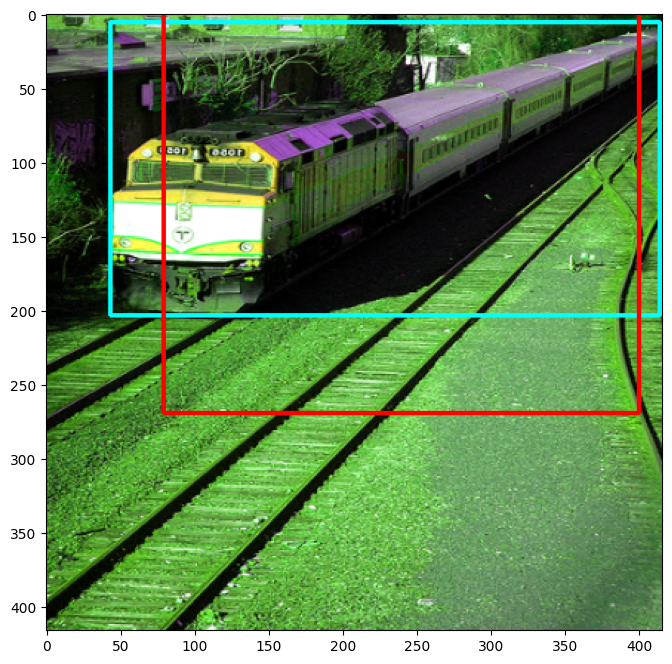

In [223]:
plt.figure(figsize=(8, 8))
plt.imshow(cloned_image)